In [4]:
from astropy.table import Table, vstack, join
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import matplotlib as mpl
mpl.rcParams.update({'font.size': 20, 
							'font.family': 'STIXGeneral', 
							'mathtext.fontset': 'stix',
							'xtick.labelsize':18,
							'ytick.labelsize':18,
							'xtick.major.width':2,
							'ytick.major.width':2,
							'axes.linewidth':2,
							'lines.linewidth':3,
							'legend.fontsize':18})

In [5]:
single_masses = Table.read('../../GalaxyZoo/catalogs/GZ2_DR12_Single_Primary_SFPort_highzgal.csv')
if 'Column1' in single_masses.colnames:
    print "renaming columns"
    single_masses.rename_column('Column1', 'DR12objid')
    single_masses.rename_column('objid', 'DR7objid')
    single_masses.write('../../GalaxyZoo/catalogs/GZ2_DR12_Single_Primary_SFPort_highzgal.csv')

In [6]:
# OOPS. Need to do a left join to get the photo and spec z objects (only spec z now)
single_gz2_DR12 = Table.read('../../GalaxyZoo/catalogs/GZ2_DR12_Single_Primary_highzgal.csv')
if 'Column1' in single_gz2_DR12.colnames:
    single_gz2_DR12.rename_column('Column1', 'DR12objid')
    single_gz2_DR12.rename_column('objid', 'DR7objid')
    single_gz2_DR12.rename_column('distance', 'separation')
    single_gz2_DR12.write('../../GalaxyZooData/GZ2_DR12_Single_Primary_highzgal.csv')

In [7]:
gz2_mainphotoz = Table.read('../../GalaxyZoo/catalogs/zoo2MainPhotoz.fits')
gz2_mainspecz = Table.read('../../GalaxyZoo/catalogs/zoo2MainSpecz.fits')

gz2_main = vstack([gz2_mainspecz, gz2_mainphotoz])

## Goal: estimate the mass distribution for the galaxies that will appear in the Clump Scout project

    - Single depth imaging
    - z <= 0.06
    - f_smooth <= 0.7 
The original sample cuts were determined in `distributions.py`

In [8]:
gz2_main['DR7objid'] = gz2_main['dr7objid']
gz2_masses = join(gz2_main, single_masses, keys='DR7objid')
gz2_main_dr12 = join(gz2_main, single_gz2_DR12, keys='DR7objid')
print len(gz2_main_dr12)

257282


In [9]:
print "GZ2 Main catalog: ",len(gz2_main),  "(Missing 9343 that never recieved GZ2 label)"
print "Match full GZ2 sample to DR12 & stellar mass catalog: ", len(single_masses)
print "Match resulting catalog back to GZ2 Main: ", len(gz2_masses)
print "  --> Leaving {} galaxies not found in GZ2 Main".format(len(single_masses)-len(gz2_masses))
print "       Should these go in? They have spec-z..."

print "Galaxies without stellar masses: ", len(gz2_main) - len(gz2_masses)
print "  --> No spec z?"

GZ2 Main catalog:  285962 (Missing 9343 that never recieved GZ2 label)
Match full GZ2 sample to DR12 & stellar mass catalog:  262805
Match resulting catalog back to GZ2 Main:  253870
  --> Leaving 8935 galaxies not found in GZ2 Main
       Should these go in? They have spec-z...
Galaxies without stellar masses:  32092
  --> No spec z?


In [12]:
# OLDER (1/12/17): I came at this from a funny angle
# Isolate non-Stripe 82 galaxies.
non_stripe82 = ((gz2_masses['ra_2'] > 60.) & (gz2_masses['ra_2'] < 300.))

print "Of the {} galaxies in GZ2 Main with stellar masses, ".format(len(gz2_masses))
print "   {} are in Stripe 82".format(len(gz2_masses)-np.sum(non_stripe82))

gz2_masses_nonS82 = gz2_masses[non_stripe82]

print "There are {} non-stripe82 galaxies with stellar masses.".format(253870-11376)

 Of the 253870 galaxies in GZ2 Main with stellar masses, 
   11376 are in Stripe 82
There are 242494 non-stripe82 galaxies with stellar masses.


## For Clump Scout 
    1. Only objects that had GZ2 morphology
    2. only objects that have spec z
    3. only objects that are NOT in stripe82
    4. determine fraction of these that have stellar mass (and distribution)
        and compare to the full sample

In [13]:
# Only objects that had GZ2 morphology AND that have spec z (because I fucked up the join)
have_morph = join(single_gz2_DR12, gz2_main, keys='DR7objid')
print "Gals with GZ2 morph and spec-z: ", len(have_morph)

# Only objects that are non stripe82
have_morph_z_nonS82 = have_morph[(have_morph['ra']>60) & (have_morph['ra']<300)]
print "Gals also NOT in stripe 82:", len(have_morph_z_nonS82)

# Only those that have stellar masses
have_morph_z_nonS82_mass = join(have_morph_z_nonS82, single_masses, keys='specObjID')
print "Gals that also have stellar mass: ", len(have_morph_z_nonS82_mass)

Gals with GZ2 morph and spec-z:  257282
Gals also NOT in stripe 82: 245580
Gals that also have stellar mass:  242602


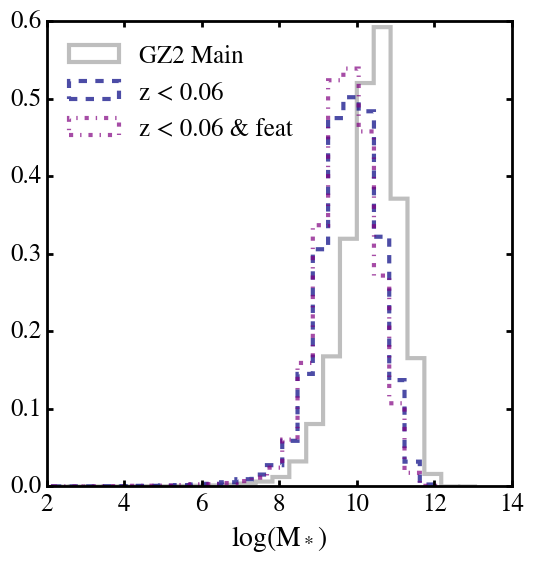

In [15]:
# Now we can look at the distribution of stellar masses!

smooth = 't01_smooth_or_features_a01_smooth_debiased'

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.hist(have_morph_z_nonS82_mass['logMass'], bins=25, normed=True, histtype='step', 
        color='darkgrey', alpha=0.75, lw=3, label='GZ2 Main')

lowzgals = have_morph_z_nonS82_mass[have_morph_z_nonS82_mass['z_1']<=0.06]
ax.hist(lowzgals['logMass'], normed=True, 
        bins=25, histtype='step', ls='--', lw=3,
        color='navy', alpha=0.7, label='z < 0.06')

lowzfeatgals = lowzgals[lowzgals[smooth]<=0.7]
ax.hist(lowzfeatgals['logMass'], normed=True, 
        bins=25, histtype='step', ls='-.', lw=3,
        color='purple', alpha=0.7, label='z < 0.06 & feat')

ax.set_xlabel(r'log(M$_*$)')
ax.legend(loc='upper left', frameon=False)

In [42]:
print "Low-z, nonS82:",np.sum(have_morph_z_nonS82['z']<0.06)
print "Low-z and high feat: ",np.sum((have_morph_z_nonS82['z']<=0.06) & 
                                     (have_morph_z_nonS82[smooth]<0.7))
print "Low-z, nonS82, w/ mass:", np.sum(have_morph_z_nonS82_mass['z_1']<=0.06)
print "Low-z and high feat w mass: ", np.sum((have_morph_z_nonS82_mass['z_1']<=0.06) & 
                                             (have_morph_z_nonS82_mass[smooth]<=0.7))

 Low-z, nonS82: 83204
Low-z and high feat:  66212
Low-z, nonS82, w/ mass: 81915
Low-z and high feat w mass:  65225


So this is interesting.  The GZ2 Main sample (non-stripe82) contains 242K galaxies with stellar masses. Of these, 81845 have z < 0.06 (WOW.) And of those, 65166 have f_smooth < 0.7. This is definitely more than we had before which is due to my new cross-matching with DR12 data. I suspect that there are thousands more galaxies with new spectroscopy since DR7. 

Should probably double check and ensure that this is true and not due to yet another screw-up of my cross-matching. If these numbers hold, THESE are the galaxies that should go into Clump Scout. 

In [44]:
# Make a catalog of the new clump scout sample
clumpscout = have_morph_z_nonS82[(have_morph_z_nonS82['z']<=0.06)&
                                 (have_morph_z_nonS82[smooth]<0.7)]
print len(clumpscout)


clumpscout_masses = join(clumpscout, single_masses, keys='DR7objid',
                         join_type='left', metadata_conflicts='warn')
print len(clumpscout_masses)

# Want to add a url to jpeg img
from SDSSutils.jpegs import jpegCreator as jc

urls = []
for ra, dec in zip(clumpscout_masses['ra_1'], clumpscout_masses['dec_1']):
    urls.append(jc.jpegURL(ra=ra, dec=dec).url)

66212
66212


In [ ]:

clumpscout_masses['url'] = urls
clumpscout_masses.write('../data/clumpscoutsample_DR12.fits')

f_smooth <= 0.6: 57768
f_smooth <= 0.8: 73188


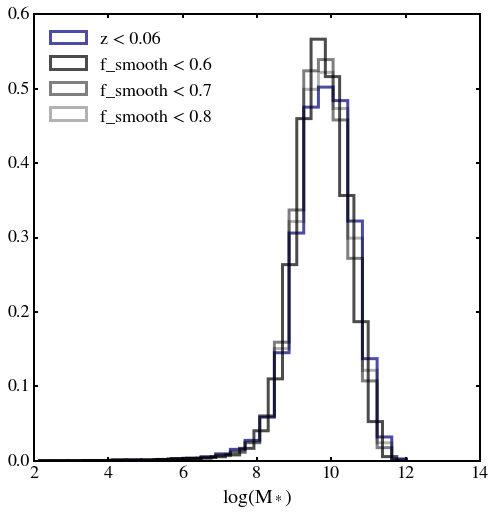

In [152]:
# Testing other f_smooth cuts 

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

ax.hist(lowzgals['logMass'], bins=25, histtype='step', lw=3,  normed=True,
        color='navy', alpha=0.7, label='z < 0.06')

lowzfeat2 = np.where(lowzgals[smooth] <= 0.6)
print "f_smooth <= 0.6:",len(lowzfeat2[0])
ax.hist(lowzgals['logMass'][lowzfeat2], normed=True,
        bins=25, histtype='step', lw=3,
        color='k', alpha=0.7, label='f_smooth < 0.6')

lowzfeat = np.where(lowzgals[smooth] <= 0.7)
ax.hist(lowzgals['logMass'][lowzfeat],  normed=True,
        bins=25, histtype='step', lw=3,
        color='k', alpha=0.5, label='f_smooth < 0.7')

lowzfeat3 = np.where(lowzgals[smooth] <= 0.8)
print "f_smooth <= 0.8:", len(lowzfeat3[0])
ax.hist(lowzgals['logMass'][lowzfeat3], normed=True,
        bins=25, histtype='step',  lw=3,
        color='k', alpha=0.3, label='f_smooth < 0.8')

ax.set_xlabel(r'log(M$_*$)')
ax.legend(loc='upper left', frameon=False)


In [67]:
# Test that the new sample for Clump Scout fully encompasses the old sample
# Need the DR7 data. 

CSsample1 = Table.read('../clumpyzoo/GZ2_no-s82_low-z_low-smooth_clumpzoo.fits')
print CSsample1.colnames

['id', 'name', 'ra', 'dec', 'stripe82', 'stripe82_coadd', 'extra_original', 'external_ref', 'JID', 'nairRA', 'nairDEC', 'TType', 'flag', 'dist', 'subject_id', 'sum_of_votes', 'classification_count', 'image_name', 'Rp', 'bflag', 'elipt', 'C', 'A', 'G', 'M20', 'Rpflag', 'specobjid', 'dr8objid', 'dr7objid', 'rastring', 'decstring', 'sample', 'gz2class', 'total_classifications', 'total_votes', 't01_smooth_or_features_a01_smooth_count', 't01_smooth_or_features_a01_smooth_weight', 't01_smooth_or_features_a01_smooth_fraction', 't01_smooth_or_features_a01_smooth_weighted_fraction', 't01_smooth_or_features_a01_smooth_debiased', 't01_smooth_or_features_a01_smooth_flag', 't01_smooth_or_features_a02_features_or_disk_count', 't01_smooth_or_features_a02_features_or_disk_weight', 't01_smooth_or_features_a02_features_or_disk_fraction', 't01_smooth_or_features_a02_features_or_disk_weighted_fraction', 't01_smooth_or_features_a02_features_or_disk_debiased', 't01_smooth_or_features_a02_features_or_disk_fl

In [169]:
CSsample2 = have_morph_z_nonS82[(have_morph_z_nonS82['z']<=0.06) & 
                                (have_morph_z_nonS82[smooth]<=0.7)]
print len(CSsample1), len(CSsample2)

overlap = set(CSsample1['OBJID']) & set(CSsample2['dr7objid'])
insample1_notsample2 = set(CSsample1['OBJID']).difference(set(CSsample2['dr7objid']))

print "{} match to our previous CS sample based on DR7 data".format(len(overlap))
print "{} of current sample not found in previous sample.".format(len(insample1_notsample2))

43762 66215
42947 match to our previous CS sample based on DR7 data
815 of current sample not found in previous sample.


## Why were 1211 galaxies NOT found in our current sample?  (1/12/17)

### Reason 1: I am assuming that they have masses? 
    YES. When we go back a step before we selected out for mass, we recover 396 more galaxies. Down to 815 missing from original sample. 
### Reason 2: I am missing 931 galaxies that have spectra in DR7 but which I didin't find in DR12?       
    YES. Matching in TOPCAT, I find that of the 931 galaxies wherein I don't have DR12 spec but which have DR7 spec, 477 are in the Clump Scout sample. Down to 338 missing.
### Reason 3: I made the original sample wrong? 
    YES. I did not use debiased vote fractions!!! 150 galaxies shouldn't even be in the original sample. Down to 188 missing. 

### According to TOPCAT, we should only be missing 144 from the original sample. We have 44 to account for.
# Fuck it. close enough. Let's choose Mass bins

In [188]:
# What should the bins be?
# To what mass are we complete in the choosen redshift range?

DR12_mass = have_morph_z_nonS82_mass
print len(DR12_mass)
DR12_mass_cs = DR12_mass[(DR12_mass['z_1']<=0.06) & (DR12_mass[smooth]<=0.7)]
print len(DR12_mass_cs)

print DR12_mass_cs.colnames

242602
65225
['int_id', 'ra1', 'dec1', 'DR7objid_1', 'DR12objid_1', 'separation', 'ra2', 'dec2', 'specObjID', 'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i', 'petroMag_z', 'petroMagErr_u', 'petroMagErr_g', 'petroMagErr_r', 'petroMagErr_i', 'petroMagErr_z', 'extinction_u', 'extinction_g', 'extinction_r', 'extinction_i', 'extinction_z', 'petroR50_r', 'petroR50Err_r', 'petroR90_r', 'petroR90Err_r', 'petror50_i', 'petroR50Err_i', 'petroR90_i', 'petroR90Err_i', 'z_1', 'specobjid', 'dr8objid', 'dr7objid', 'ra_1', 'dec_1', 'rastring', 'decstring', 'sample', 'gz2class', 'total_classifications', 'total_votes', 't01_smooth_or_features_a01_smooth_count', 't01_smooth_or_features_a01_smooth_weight', 't01_smooth_or_features_a01_smooth_fraction', 't01_smooth_or_features_a01_smooth_weighted_fraction', 't01_smooth_or_features_a01_smooth_debiased', 't01_smooth_or_features_a01_smooth_flag', 't01_smooth_or_features_a02_features_or_disk_count', 't01_smooth_or_features_a02_features_or_disk_weight', 

In [239]:
color = []
for mag in DR12_mass_cs['mag_r']:
    if mag > 16.5:
        color.append('blue')
    elif mag > 15.9 and mag <= 16.5:
        color.append('cyan')
    elif mag > 15. and mag <= 15.9:
        color.append('lime')
    elif mag <= 15.:
        color.append('orange')

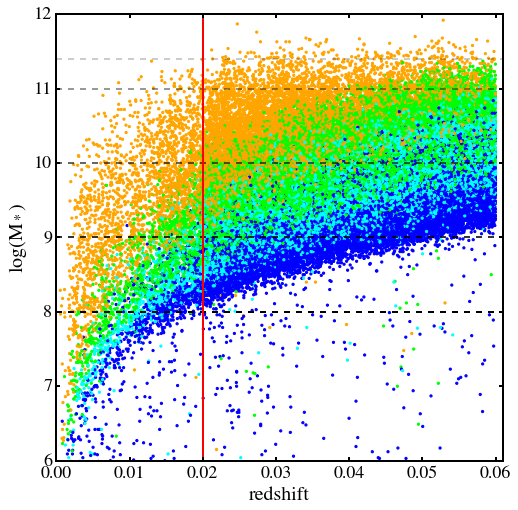

In [275]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

ax.scatter(DR12_mass_cs['z_1'], DR12_mass_cs['logMass'], marker='.', color=color)
ax.axhline(y=11.4, ls='--', color='k', alpha=0.2, lw=2)
ax.axhline(y=11, ls='--', color='k', alpha=.4, lw=2)
ax.axhline(y=10, ls='--', color='k', alpha=.6, lw=2)
ax.axhline(y=9, ls='--', color='k', alpha=.8, lw=2)
ax.axhline(y=8, ls='--', color='k', alpha=1., lw=2)

ax.axvline(x=.02, color='r', lw=2)

ax.set_xlim(0., 0.061)
ax.set_ylim(6, 12)

ax.set_xlabel('redshift')
ax.set_ylabel(r'log(M$_*$)')

In [268]:
# Explaination: Because I am now using DR12 photometry, there are a small portion of galaxies
#      with photometry fainter than the original cuts of 17.0 (for the main sample) and 
#      17.7 (for the stripe 82 sample). 

# I should probably take a brief look at how many galaxies recieve drastically different 
# photometry as well as by how different. 

print np.sum(DR12_mass_cs['mag_r']>17.7)
print np.sum(DR12_mass_cs['mag_r']>16.5)
print np.sum( (DR12_mass_cs['mag_r']>15.9) & (DR12_mass_cs['mag_r']<=16.5))
print np.sum( (DR12_mass_cs['mag_r']>15.) & (DR12_mass_cs['mag_r']<=15.9))
print np.sum( (DR12_mass_cs['mag_r']<=15.))

490
18227
17605
18161
11232


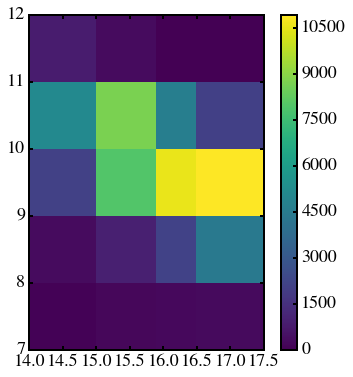

In [321]:
xdata = DR12_mass_cs['logMass']
ydata = DR12_mass_cs['mag_r']

yedges = [7,8,9,10,11,12]
#yedges = np.arange(7,12, 0.1)

xedges = [14., 15., 15.9, 16.5, 17.7]
#xedges = np.arange(14,18, 0.1)

H, xedges, yedges = np.histogram2d(ydata, xdata, bins=(xedges, yedges))

X, Y = np.meshgrid(xedges, yedges)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
cax = ax.pcolormesh(X,Y,H.T, cmap='viridis')
ax.set_aspect('equal')
ax.set_xlim(14,17.5)

# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])# vertically oriented colorbar

For each mass bin, take a random sample from each magnitude bin. find a few to which I can, more or less, easily add artifical clumps. The range of magnitude bins will account for changes in luminosity. The range of masses will account for... masses. 

If we try to do two samples: 

| | Redshift range | Mass completion | # of bins |
|---|:------------:|:---------------:|----------:|
|Sample 1 | 0 < z < 0.02 | 8 < log(M) < 10 | 6  |
|Sample 2 | 0.02 < z < 0.06 | 9 < log(M) < 11.5 | 7-8| 

I think luminosity and mass are the two most important variables to account for, especially when considering the f_clumpy project. Obviously, we'll want to account for mass (as Guo and many other do) but because we're considering such low redshift stuff, we will probably also want to account for luminosity evolution. A log(M) = 9 galaxy of today is not guaranteed to be self similar to a log(M) = 9 galaxy at z = 1. 

I'm less concerned about determining completeness as a function of radial distance because I don't plan on undertaking the Clump Properties for All the SDSS galaxies project. I plan on doing the small sample project that I currently have and leaving it at that. However, someone else may pick up the project when I leave so I suppose I should figure out how to estimate this. 

In [ ]:
plot all the clump spectra atop each other
normalize to Vband 
get a feel for color; emission line flux

talk to Vihang about fitting average spectra
talk to Hugh about fitting 